 - L1 & L2 的差別
    - [LINK](https://discuss.pytorch.org/t/how-is-your-experience-of-using-l1-regularization/153565)
 - 注意tensor和scalar<font color=yellow>不要混用</font>
 - 備註
    - 我沒有切Validation

In [1]:
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torch.optim import SGD
from torchvision.transforms import ToTensor, Compose
from torch.nn import CrossEntropyLoss
import torch
from torch.nn.functional import one_hot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# hyper-parameter
batch_size = 256
epochs = 50
lambd = 0.01
reg = 'L1' # None, 'L1', 'L2'

In [ ]:
train_data = FashionMNIST('data', train=True, transform=ToTensor()
                          , download=True)
test_data = FashionMNIST('data', train=False, transform=ToTensor()
                          , download=True)

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

 76%|███████▌  | 20.0M/26.4M [00:14<00:03, 1.68MB/s]

In [ ]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(), 
            nn.BatchNorm1d(784),
            nn.Linear(784, 10)
        )
    def forward(self, X):
        return self.net(X)

In [ ]:
model = Module()
optimizer = SGD(model.parameters())
loss = CrossEntropyLoss()

In [ ]:
history = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[]}
for i in range(epochs):
    print(f'==== Epoch {i + 1} start! ============================')
    model.train()
    training_acc = 0
    training_loss = 0
    for data in train_loader:
        img, label = data
        output = model(img)
        output_loss = loss(output, label.long())
        # record
        training_loss = training_loss + output_loss.item() # 因為原本是tensor
        training_acc = training_acc + (output.argmax(dim=1) == label).sum().item() # 原本是tensor
        # Regularization
        if reg == 'L1': # L1 Norm
            loss = loss + sum(param.norm(1) for param in model.parameters())
        elif reg == 'L2': # L2 Norm
            loss = loss + sum(param.norm(2) for param in model.parameters())
        # BP
        optimizer.zero_grad()
        output_loss.backward()
        optimizer.step()
    history['loss'].append(training_loss / len(train_data))
    history['acc'].append(training_acc / len(train_data))
    model.eval()
    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            output = model(img)
            test_acc = test_acc + (output.argmax(dim=1) == label).sum().item()
            test_loss = test_loss + loss(output, label).item()
    history['val_acc'].append(test_acc / len(test_data))
    history['val_loss'].append(test_loss / len(test_data))
    print(f'Training Accuracy {training_acc / len(train_data):.4f}, training loss: {training_loss / len(train_data):.4f}')
    print(f'Test Accuracy: {test_acc / len(test_data):.4f}, test loss: {test_loss / len(test_data):.4f}')
    print('===================== End ========================')
    print()

==== Epoch 1 start! ============================
Training Accuracy 0.5874, training loss: 0.0053
Test Accuracy: 0.6961, test loss: 0.0040
===================== End ========================

==== Epoch 2 start! ============================
Training Accuracy 0.7195, training loss: 0.0035
Test Accuracy: 0.7308, test loss: 0.0033
===================== End ========================

==== Epoch 3 start! ============================
Training Accuracy 0.7463, training loss: 0.0031
Test Accuracy: 0.7515, test loss: 0.0030
===================== End ========================

==== Epoch 4 start! ============================
Training Accuracy 0.7632, training loss: 0.0028
Test Accuracy: 0.7642, test loss: 0.0029
===================== End ========================

==== Epoch 5 start! ============================
Training Accuracy 0.7746, training loss: 0.0027
Test Accuracy: 0.7713, test loss: 0.0027
===================== End ========================

==== Epoch 6 start! ============================
T

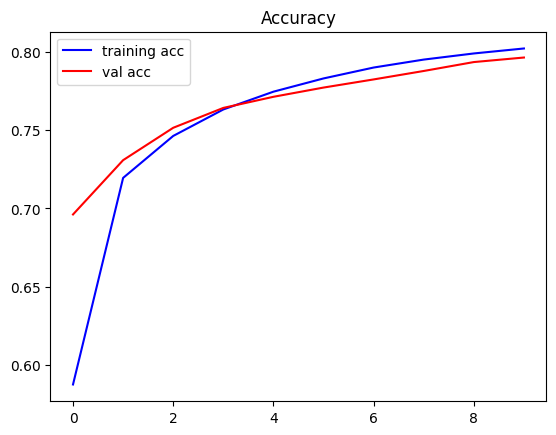

In [ ]:
plt.clf(); plt.cla() # clean
plt.plot(history['acc'], 'b', label='training acc')
plt.plot(history['val_acc'], 'r', label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

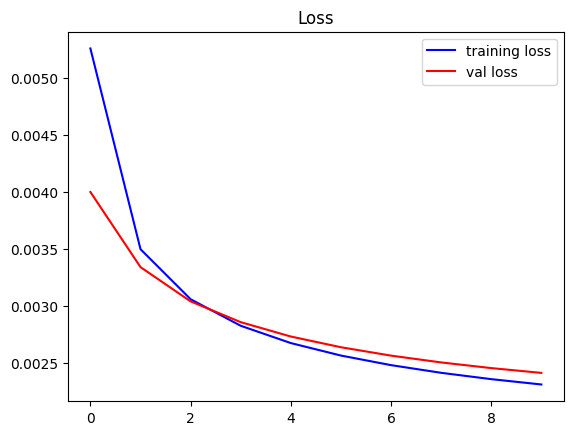

In [ ]:
plt.clf(); plt.cla() # clean
plt.plot(history['loss'], 'b', label='training loss')
plt.plot(history['val_loss'], 'r', label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

 - 視覺化

In [ ]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in test_loader:
        img, label = data
        output = model(img).argmax(1)
        true_label.extend(label.numpy())
        pred_label.extend(output.numpy())
        

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_data.classes), 
      sep='\n')

Accuracy 0.7964
Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.79      0.78      1000
     Trouser       0.97      0.93      0.95      1000
    Pullover       0.73      0.66      0.69      1000
       Dress       0.76      0.86      0.80      1000
        Coat       0.69      0.75      0.72      1000
      Sandal       0.82      0.85      0.83      1000
       Shirt       0.57      0.44      0.50      1000
     Sneaker       0.84      0.86      0.85      1000
         Bag       0.91      0.91      0.91      1000
  Ankle boot       0.88      0.92      0.90      1000

    accuracy                           0.80     10000
   macro avg       0.79      0.80      0.79     10000
weighted avg       0.79      0.80      0.79     10000



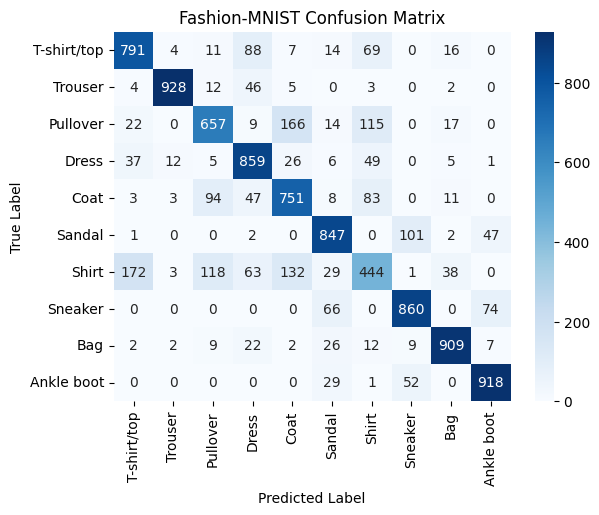

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Fashion-MNIST Confusion Matrix")
plt.show()